In [89]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random
import sys
from itertools import combinations

def seed():
    random.seed(1)

In [175]:
a = "flying fish flew by the space station"
b = "he will not allow you to bring your sticks of dynamite and pet armadillo along"
c = "he figured a few sticks of dynamite were easier than a fishing pole to catch an armadillo"

strs = [a,b,c]

In [176]:
def kshingle(s: str, k:int=2):
    tokens = set()
    for i in range(len(s[:-k+1])):
        token = s[i:i+k]
        tokens.add(token)
    return tokens

atokens = kshingle(a)
btokens = kshingle(b)
ctokens = kshingle(c)

In [177]:
def build_vocab(tokens):
    vocab = tokens[0]
    for t in tokens[1:]:
        vocab = vocab.union(t)
    vocab = list(vocab)
    random.shuffle(vocab)
    return vocab

seed()
vocab = build_vocab([atokens, btokens, ctokens])

In [178]:
np.array(vocab).shape, np.array(list(atokens)).shape

((103,), (32,))

In [179]:
def gethot(tokens, vocab):
    return [1 if x in tokens else 0 for x in vocab]

a1hot = gethot(atokens, vocab)
b1hot = gethot(btokens, vocab)
c1hot = gethot(ctokens, vocab)

In [180]:
def unstack(a, axis=0):
  return np.moveaxis(a, axis, 0)

def create_minhash_hashlists(vocab_size: int, n=20):
  hashlist = []
  for i in range(n):
    arr = list(range(1, vocab_size+1))
    random.shuffle(arr)
    hashlist.append(arr.copy())
  return hashlist

In [181]:
# cpu version
def minhash_cpu(onehots: np.array, hashlists, bs=50):
    h = np.array(hashlists)
    sigidx = np.zeros((h.shape[0], onehots.shape[0]))

    # fix zeros on arr resulting in 0 after multiplication
    n = onehots.shape[0]
    t_h = h
    for i in range(0, onehots.shape[0], bs):
        s = slice(i, min(i+bs, n))
        t_onehots = onehots[s]

        arr = np.einsum('ij,kj->ikj', t_h, t_onehots)
        arr[arr == 0] = 2**63-1
        # sigidx is uniformally distributed, thereby used as hash
        sigidx[:,s] = arr.argmin(axis=2)

    return sigidx

def minhash_gpu(onehots: np.array, hashlists, bs=50):
    h = np.array(hashlists)
    sigidx = np.zeros((h.shape[0], onehots.shape[0]))

    # fix zeros on arr resulting in 0 after multiplication
    n = onehots.shape[0]
    t_h = torch.from_numpy(h).cuda()
    for i in range(0, onehots.shape[0], bs):
        s = slice(i, min(i+bs, n))
        t_onehots = torch.from_numpy(onehots[s]).cuda()

        arr = torch.einsum('ij,kj->ikj', t_h, t_onehots)
        arr[arr == 0] = 2**63-1
        # sigidx is uniformally distributed, thereby used as hash
        sigidx[:,s] = arr.argmin(axis=2).cpu()

    return sigidx

In [182]:
seed()
hashlists = create_minhash_hashlists(len(vocab))

In [183]:
arrs = []
for i in range(2000):
  arr = np.random.choice([0, 1], size=len(a1hot), p=[.5, .5])
  arrs.append(arr)

In [184]:
%timeit -n10 sigs = minhash_cpu(np.array(arrs), hashlists)

37.8 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [185]:
%timeit -n10 sigs = minhash_gpu(np.array(arrs), hashlists)

7.89 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [186]:
seed()
hashlists = create_minhash_hashlists(len(vocab))
sigs = minhash_gpu(np.array([a1hot, b1hot, c1hot]), hashlists)
asig, bsig, csig = unstack(sigs, axis=1)

In [187]:
a = np.array(np.array_split(sigs, 10, axis=0)).astype('str')
tmp = np.char.add(a[:,0], ',')
np.char.add(tmp, a[:,1])

array([['73.0,89.0', '84.0,89.0', '76.0,89.0'],
       ['67.0,63.0', '12.0,60.0', '55.0,60.0'],
       ['64.0,1.0', '64.0,87.0', '11.0,87.0'],
       ['26.0,89.0', '97.0,7.0', '92.0,79.0'],
       ['23.0,95.0', '66.0,96.0', '24.0,21.0'],
       ['56.0,70.0', '12.0,90.0', '13.0,58.0'],
       ['38.0,30.0', '3.0,13.0', '53.0,13.0'],
       ['17.0,67.0', '30.0,89.0', '17.0,89.0'],
       ['64.0,65.0', '79.0,7.0', '52.0,6.0'],
       ['75.0,95.0', '75.0,55.0', '75.0,55.0']], dtype='<U65')

In [188]:
def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

jaccard(atokens, btokens), jaccard(set(asig), set(bsig))

(0.14814814814814814, 0.13793103448275862)

In [189]:
class LSH:
    def __init__(self, b):
        self.b = b
        # buckets maps between matching sig fragments and IDs
        # A whole list should be inserted as-is so its indexes match the bucket IDs
        self.buckets = []
        self.counter = 0
        for i in range(b):
            self.buckets.append({})

    def add_hashes(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        subvecs = self.split_vec(sigs).astype('str')
        tmp = np.char.add(subvecs[:,0], ',')
        subvecs = np.char.add(tmp, subvecs[:,1])
        for sig_subvecs in subvecs.T:
            for i, subvec in enumerate(sig_subvecs):
                if subvec not in self.buckets[i].keys():
                    self.buckets[i][subvec] = []
                self.buckets[i][subvec].append(self.counter)
            self.counter += 1

    def split_vec(self, sigs):
        if isinstance(sigs, list):
            sigs = np.array(sigs).T

        sig_len, sigs_num = np.shape(sigs)
        assert(self.b < sig_len)
        assert((np.any(sig_len % self.b) != 0) == False)

        return np.array(np.array_split(sigs, self.b, axis=0))

    def check_candidates(self):
        candidates = []
        for band in self.buckets:
            for keys, hits in band.items():
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))

        return set(candidates)

lsh = LSH(10)
lsh.add_hashes([asig, bsig, csig])
lsh.buckets

[{'73.0,89.0': [0], '84.0,89.0': [1], '76.0,89.0': [2]},
 {'67.0,63.0': [0], '12.0,60.0': [1], '55.0,60.0': [2]},
 {'64.0,1.0': [0], '64.0,87.0': [1], '11.0,87.0': [2]},
 {'26.0,89.0': [0], '97.0,7.0': [1], '92.0,79.0': [2]},
 {'23.0,95.0': [0], '66.0,96.0': [1], '24.0,21.0': [2]},
 {'56.0,70.0': [0], '12.0,90.0': [1], '13.0,58.0': [2]},
 {'38.0,30.0': [0], '3.0,13.0': [1], '53.0,13.0': [2]},
 {'17.0,67.0': [0], '30.0,89.0': [1], '17.0,89.0': [2]},
 {'64.0,65.0': [0], '79.0,7.0': [1], '52.0,6.0': [2]},
 {'75.0,95.0': [0], '75.0,55.0': [1, 2]}]

In [190]:
candidates = list(lsh.check_candidates())
cnd1 = candidates[0][0]
cnd2 = candidates[0][1]
print("Found match:")
print(strs[cnd1])
print(strs[cnd2])

Found match:
he will not allow you to bring your sticks of dynamite and pet armadillo along
he figured a few sticks of dynamite were easier than a fishing pole to catch an armadillo


In [191]:
lsh = LSH(10)
bands = lsh.split_vec([asig, bsig, csig])
band_a, band_b, band_c = unstack(bands, axis=2)
print(band_b.T)

[[84. 12. 64. 97. 66. 12.  3. 30. 79. 75.]
 [89. 60. 87.  7. 96. 90. 13. 89.  7. 55.]]


In [192]:
np.any(np.all(band_b == band_c, axis=1))

True

In [193]:
def check(band1, band2):
  return np.any(np.all(band1 == band2, axis=1))

check(band_a, band_b), check(band_a, band_c), check(band_b, band_c)

(False, False, True)

In [161]:
# test on big dataset
import requests
import pandas as pd
import io

url = "https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt"

text = requests.get(url).text

data = pd.read_csv(io.StringIO(text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [162]:
sentences = data['sentence_A'].tolist()

In [163]:
k = 8  # shingle size

shingles = [kshingle(s, k) for s in sentences]
vocab = build_vocab(shingles)
shingles_1hot = [gethot(s, vocab) for s in shingles]

# stack into single numpy array
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape

(4500, 37181)

In [164]:
shingles_1hot[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [165]:
sum(shingles_1hot[0])  # confirm we have 1s

74

In [166]:
hashlists = create_minhash_hashlists(len(vocab), n=100)
sigs = minhash_gpu(shingles_1hot, hashlists)
sigs[0].shape

(4500,)

In [167]:
b = 20

lsh = LSH(b)
lsh.add_hashes(sigs)
candidate_pairs = lsh.check_candidates()
len(candidate_pairs)

78584

In [169]:
from sklearn.metrics.pairwise import cosine_similarity

pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'jaccard': [],
    'cosine': [],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = sigs[:,x]
    vector_y = sigs[:,y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    pairs = pairs.append({
            'x': x,
            'y': y,
            'jaccard': jaccard(set(vector_x), set(vector_y)),
            'cosine': cosine,
            'candidate': candidate
        }, ignore_index=True)

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

Streaming output truncated to the last 5000 lines.
<ipython-input-169-44e78bf23449>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
<ipython-input-169-44e78bf23449>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
<ipython-input-169-44e78bf23449>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
<ipython-input-169-44e78bf23449>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
<ipython-input-169-44e78bf23449>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<Axes: xlabel='cosine', ylabel='candidate'>

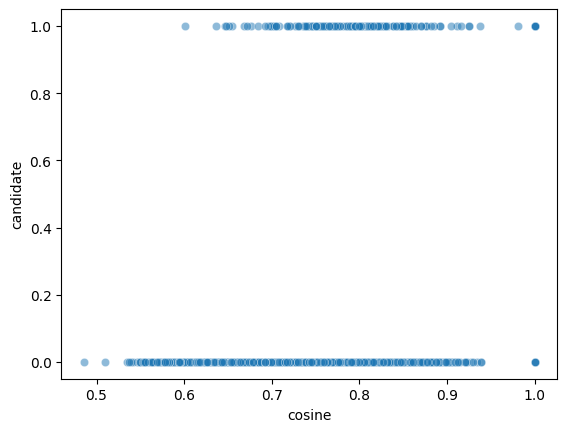

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.5)

In [171]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

<Axes: xlabel='cosine', ylabel='candidate'>

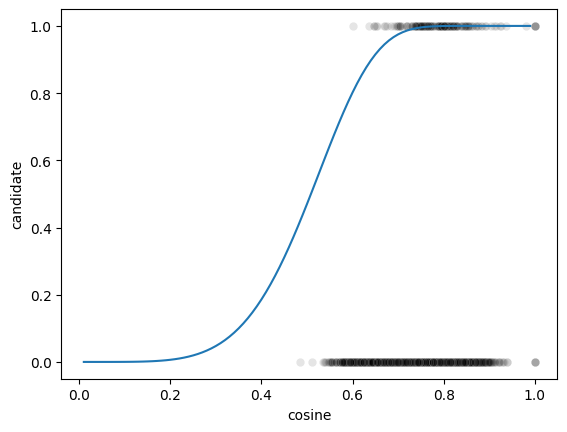

In [172]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.1, color='k')

<Axes: xlabel='cosine_norm', ylabel='candidate'>

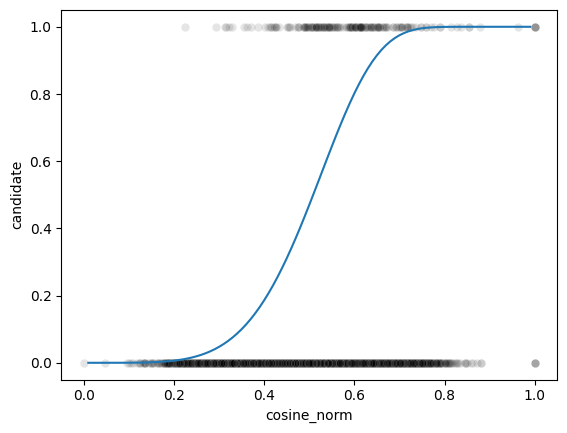

In [173]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.1, color='k')

<ipython-input-174-2dede05a89d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
<ipython-input-174-2dede05a89d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
<ipython-input-174-2dede05a89d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
<ipython-input-174-2dede05a89d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
<ipython-input-174-2dede05a89d1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

<Axes: xlabel='s', ylabel='P'>

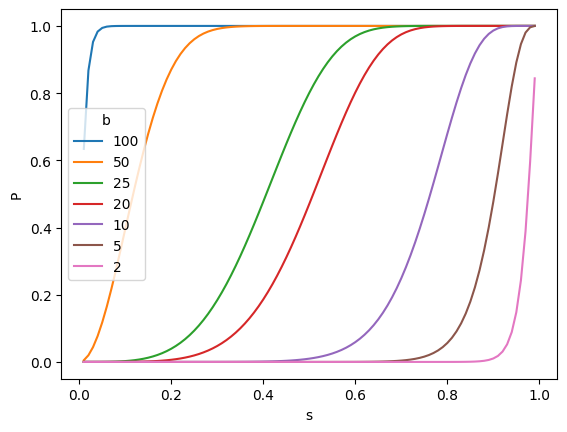

In [174]:
probs = pd.DataFrame({
    'P': [],
    's': [],
    'b': []
})

for b in [100, 50, 25, 20, 10, 5, 2]:
    r = int(100 / b)
    s_scores = np.arange(0.01, 1, 0.01)
    P_scores = [probability(s, r, b) for s in s_scores]
    probs = probs.append(pd.DataFrame({
        'P': P_scores,
        's': s_scores,
        'b': [str(b)]*len(s_scores)
    }), ignore_index=True)

sns.lineplot(data=probs, x='s', y='P', hue='b')